# Import the data and explore it

In [1]:
# Data libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io.wavfile as sci_wav  # Open wav files
import os  # Manipulate files
import warnings  # Warning removal
warnings.filterwarnings('ignore')

# List the wav files
ROOT_DIR = '../input/cats_dogs/'
X_path = os.listdir(ROOT_DIR)
y = [0 if 'cat' in f else 1 for f in X_path]  # change y to int values

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.33)

print("in X, there is {} cats and {} dogs".format(len(y) - sum(y), sum(y)))
print("in X_train, there is {} cats and {} dogs".format(len(y_train) - sum(y_train), sum(y_train)))
print("in X_test, there is {} cats and {} dogs".format(len(y_test) - sum(y_test), sum(y_test)))

in X, there is 164 cats and 113 dogs
in X_train, there is 108 cats and 77 dogs
in X_test, there is 56 cats and 36 dogs


### Read an audio Wave 

In [2]:
def read_wav_files(wav_files):
    '''Returns a list of audio waves
    Params:
        wav_files: List of .wav paths
    
    Returns:
        List of audio signals
    '''
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [sci_wav.read(ROOT_DIR + f)[1] for f in wav_files]

print(read_wav_files('cat_1.wav'))
print(read_wav_files(['cat_1.wav', 'cat_2.wav']))

X_train, X_test = map(read_wav_files, [X_train, X_test])

[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16)]
[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16), array([-1028, -1039, -1064, ...,     6,    38,     2], dtype=int16)]


### Count recorded time for 'cat' and recorded time for 'dog'

In [3]:
X_all = read_wav_files(X_path)
X_all_cat = [_x for _x, _y in zip(X_all, y) if _y == 0]
X_all_dog = [_x for _x, _y in zip(X_all, y) if _y == 1]
X_all_cat = np.concatenate(X_all_cat)
X_all_dog = np.concatenate(X_all_dog)

print('Overall, there is {:.2f}sec of cats and {:.2f}sec of dogs'.format(
    len(X_all_cat) / 16000, len(X_all_dog) / 16000))

Overall, there is 1323.90sec of cats and 598.44sec of dogs


### Generate what'll be the official train/test split

In [4]:
import pandas as pd
import random

# Randomize cat and dog file paths
cat_paths = [_x for _x, _y in zip(X_path, y) if _y == 0]
dog_paths = [_x for _x, _y in zip(X_path, y) if _y == 1]
random.shuffle(cat_paths)
random.shuffle(dog_paths)

n = int(len(cat_paths) * .3)

splits = {
    'train_cat': cat_paths[n:],
    'train_dog': dog_paths[n:],
    'test_cat': cat_paths[:n],
    'test_dog': dog_paths[:n]
}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in splits.items() ]))
df.to_csv('train_test_split.csv')

### Plot the raw audio wave

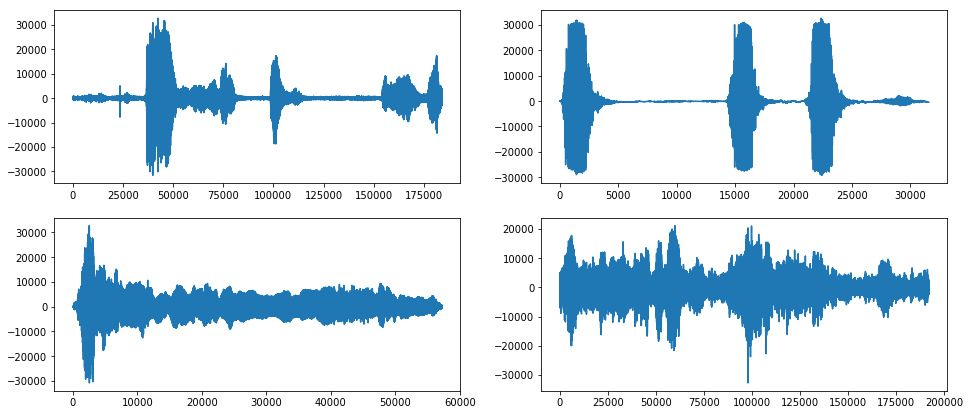

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].plot(X_train[0])
axs[0][1].plot(X_train[1])
axs[1][0].plot(X_train[2])
axs[1][1].plot(X_train[3])
plt.show()

### Define a generator

In [6]:
def cats_and_dogs_gen(dataset='train', n_samples=20, sample_len=16000):
    '''This generator is going to return batchs of size <n_sample>*<sample_len>
    
    Params:
        dataset: Either 'train' or 'test', to choose in between them
        n_samples: amount of samples per batch
        sample_len: size of the samples in a batch
    '''
    # Select between train or test
    X, y = (X_train, y_train) if dataset is 'train' else (X_test, y_test)
    
    # Create two huuuges 1D arrays with all the audio waves concatenated one after the other
    # (one for the cats, the other for the dogs)
    X_cat = np.concatenate([_x for _x, _y in zip(X, y) if _y == 0])
    X_dog = np.concatenate([_x for _x, _y in zip(X, y) if _y == 1])
    
    # Apply normalization and mean suppression
    X_cat = preprocessing.scale(X_cat)
    X_dog = preprocessing.scale(X_dog)
    
    for _ in range(int(max(sum(y), len(y) - sum(y)) / n_samples)):
        y_batch = np.zeros(n_samples)
        X_batch = np.zeros((n_samples, sample_len))
        for idx in range(n_samples):
            y_batch[idx] = idx % 2
            _X = X_cat if y_batch[idx] == 0 else X_dog
            x_idx = np.random.randint(len(_X) - sample_len)
            X_batch[idx] = _X[x_idx : x_idx + sample_len]
        
        yield (X_batch.reshape(n_samples, sample_len, 1),
               y_batch.reshape(-1, 1) )
        
# Test the generator here
x, y = next(cats_and_dogs_gen('train'))
print(x.shape, y.shape)

(20, 16000, 1) (20, 1)


# Deep Learning !!
#### But first... Let me define the model...

In [7]:
import tensorflow as tf
from collections import namedtuple

def build_neural_network():
    '''We build a 10 layer convolutional neural network ending with
    a Global average Pooling layer whose logits are submitted to
    a sigmoid function.
    
    Receptive fied is : U_0 = 1; U_{n+1} = U_n * 2 + 1
    Which is, for 10 layers : 2047
    '''
    tf.reset_default_graph()
    inputs = tf.placeholder(tf.float32, shape=[None, None, 1])
    labels = tf.placeholder(tf.float32, shape=[None, 1])
    learning_rate = tf.placeholder(tf.float32)
    is_training = tf.Variable(True,dtype=tf.bool)
    
    nn = tf.layers.conv1d(inputs,
                          filters=10,
                          kernel_size=3,
                          strides=2,
                          activation=tf.nn.relu)
    for _ in range(9):
        nn = tf.layers.conv1d(nn,
                              filters=10,
                              kernel_size=3,
                              strides=2,
                              activation=tf.nn.relu)
        nn = tf.layers.batch_normalization(nn, training=is_training)
    
    # Global average pooling
    nn = tf.reduce_mean(nn, [1])
    
    logits = tf.layers.dense(nn, 1, activation=None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    cost = tf.reduce_mean(cross_entropy)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    predicted = tf.nn.sigmoid(logits)
    correct_pred = tf.equal(tf.round(predicted), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'learning_rate','is_training', 'logits',
                    'cost', 'optimizer', 'predicted', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

model = build_neural_network()

### And now... Train it :)

In [8]:
epochs = 100
train_collect = 2
train_print = train_collect * 2

learning_rate_value = 0.01

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration=0
    for e in range(epochs):
        
        # Train
        epoch_loss = []
        epoch_acc = []
        for batch_x, batch_y in cats_and_dogs_gen('train'):
            feed = {model.inputs: batch_x,
                    model.labels: batch_y,
                    model.learning_rate: learning_rate_value,
                    model.is_training:True
                   }
            # Do the training
            batch_loss, _, batch_acc = sess.run([model.cost, model.optimizer, model.accuracy],
                                                feed_dict=feed)
            
            # Accumulate the resulting values
            epoch_loss.append(batch_loss)
            epoch_acc.append(batch_acc)
        
        # Collect epoch losses and accuracies
        x_collect.append(e)
        train_loss_collect.append(np.array(epoch_loss).mean())
        train_acc_collect.append(np.array(epoch_acc).mean())

        print("Epoch: {}/{}".format(e + 1, epochs),
              "Train Loss: {:.4f}".format(np.array(epoch_loss).mean()),
              "Train Acc: {:.4f}".format(np.array(epoch_acc).mean()))
        
        # Validation output
        epoch_loss = []
        epoch_acc = []
        for batch_x, batch_y in cats_and_dogs_gen('test'):
            feed = {model.inputs: batch_x,
                    model.labels: batch_y,
                    model.learning_rate: learning_rate_value,
                    model.is_training:True
                   }
            # Do the training
            batch_loss, _, batch_acc = sess.run([model.cost, model.optimizer, model.accuracy],
                                                feed_dict=feed)
            
            # Accumulate the resulting values
            epoch_loss.append(batch_loss)
            epoch_acc.append(batch_acc)
            
        # Collect epoch losses and accuracies
        valid_loss_collect.append(np.array(epoch_loss).mean())
        valid_acc_collect.append(np.array(epoch_acc).mean())

    saver.save(sess, "./cats_dogs.ckpt")

Epoch: 1/100 Train Loss: 0.6872 Train Acc: 0.5500
Epoch: 2/100 Train Loss: 0.6428 Train Acc: 0.6300
Epoch: 3/100 Train Loss: 0.6301 Train Acc: 0.7000
Epoch: 4/100 Train Loss: 0.4993 Train Acc: 0.8100
Epoch: 5/100 Train Loss: 0.5094 Train Acc: 0.7700
Epoch: 6/100 Train Loss: 0.5353 Train Acc: 0.7700
Epoch: 7/100 Train Loss: 0.4655 Train Acc: 0.8200
Epoch: 8/100 Train Loss: 0.4338 Train Acc: 0.8500
Epoch: 9/100 Train Loss: 0.5121 Train Acc: 0.7800
Epoch: 10/100 Train Loss: 0.5246 Train Acc: 0.7700
Epoch: 11/100 Train Loss: 0.6357 Train Acc: 0.7100
Epoch: 12/100 Train Loss: 0.5050 Train Acc: 0.7300
Epoch: 13/100 Train Loss: 0.4894 Train Acc: 0.7300
Epoch: 14/100 Train Loss: 0.4763 Train Acc: 0.7900
Epoch: 15/100 Train Loss: 0.4439 Train Acc: 0.8300
Epoch: 16/100 Train Loss: 0.5023 Train Acc: 0.7400
Epoch: 17/100 Train Loss: 0.4326 Train Acc: 0.7700
Epoch: 18/100 Train Loss: 0.4093 Train Acc: 0.8300
Epoch: 19/100 Train Loss: 0.4384 Train Acc: 0.7900
Epoch: 20/100 Train Loss: 0.4499 Train A

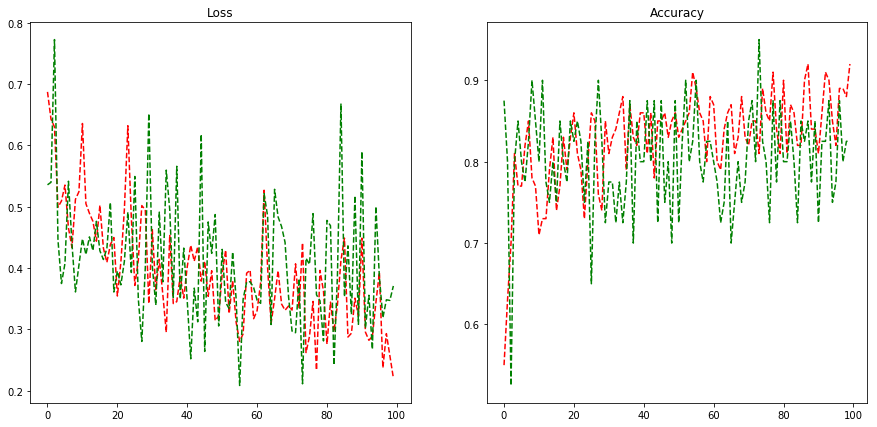

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].plot(x_collect, train_loss_collect, "r--")
axs[0].plot(x_collect, valid_loss_collect, "g--")
axs[0].set_title('Loss')
axs[1].plot(x_collect, train_acc_collect, "r--")
axs[1].plot(x_collect, valid_acc_collect, "g--")
axs[1].set_title('Accuracy')

plt.show()